In [1]:
import numpy as np
import math
import os
import glob
import pandas as pd
from pylab import *
import netCDF4 as nc
from scipy.interpolate import griddata
from scipy.interpolate import Rbf
import re
from mpl_toolkits.basemap import Basemap,shiftgrid,cm
import matplotlib.cm as cm
import numpy
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
def context2array(context):
    return np.matrix([map(float, re.split('\s+', ln.strip()))
      for ln in context.splitlines() if ln.strip()])

In [3]:
# load lons and lats
file_source = open('/ocean/xiaoxiny/research/data/findk/ice_concentration/updated_lon.dat')
line_content = file_source.readlines()
lon_ice=np.empty([10,464])
for j in range(0, 464):
     lon_ice[:,j] = context2array(line_content[j])

# reshape        
shape = ( 80, 58 )
lon2_ice=lon_ice.reshape(shape)

In [4]:
file_source = open('/ocean/xiaoxiny/research/data/findk/ice_concentration/updated_lat.dat')
line_content = file_source.readlines()
lat_ice=np.empty([10,464])
for j in range(0, 464):
     lat_ice[:,j] = context2array(line_content[j])
lat2_ice=lat_ice.reshape(shape)

In [5]:
#rearrange lon_ice,lat_ice

iconlat=np.empty([80,58])
iconlon=np.empty([80,58])

for j in range (58):
    for k in range (8):
            iconlat[k*10:(k+1)*10,j]=lat_ice[:,j*8+k]
            iconlon[k*10:(k+1)*10,j]=lon_ice[:,j*8+k]

In [6]:
yr = 1957

filename=sorted(glob.glob('/ocean/xiaoxiny/research/data/findk/ice_concentration/59,78,79/*%s*'%yr))
print filename
icon=np.empty([80,58])
for k in range(1):
    file_source=open(filename[k])
    line_content = file_source.readlines()
    for i in range (58):
        split=map(''.join, zip(*[iter(line_content[i])]))
        for j in range (len(split)-1):
            if split[j]=='*':
                split[j]=10
            if split[j]=='.':
                split[j]=-1
            icon[j,i]=split[j] 

['/ocean/xiaoxiny/research/data/findk/ice_concentration/59,78,79/1957_9']


In [7]:
icon=np.ma.masked_where(icon<0,icon)
icon=np.ma.masked_where(np.isnan(icon),icon)

In [8]:
bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]


coordinate_name=glob.glob('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/*coor*.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:,:]
nav_lat=coordinate_obj.variables['nav_lat'][:,:]
m = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
x_lon,y_lat = m(nav_lon, nav_lat)
x,y= m(iconlon,iconlat)

rbf = Rbf(x[15:52,10:-15], y[15:52,10:-15], icon[15:52,10:-15], function='linear')
icon_ = rbf(x_lon[435:-20,10:-20], y_lat[435:-20,10:-20])

icon_[icon_ < 0] = 0
icon_[icon_ > 10] = 10


In [9]:
# calculation ends
# plot results

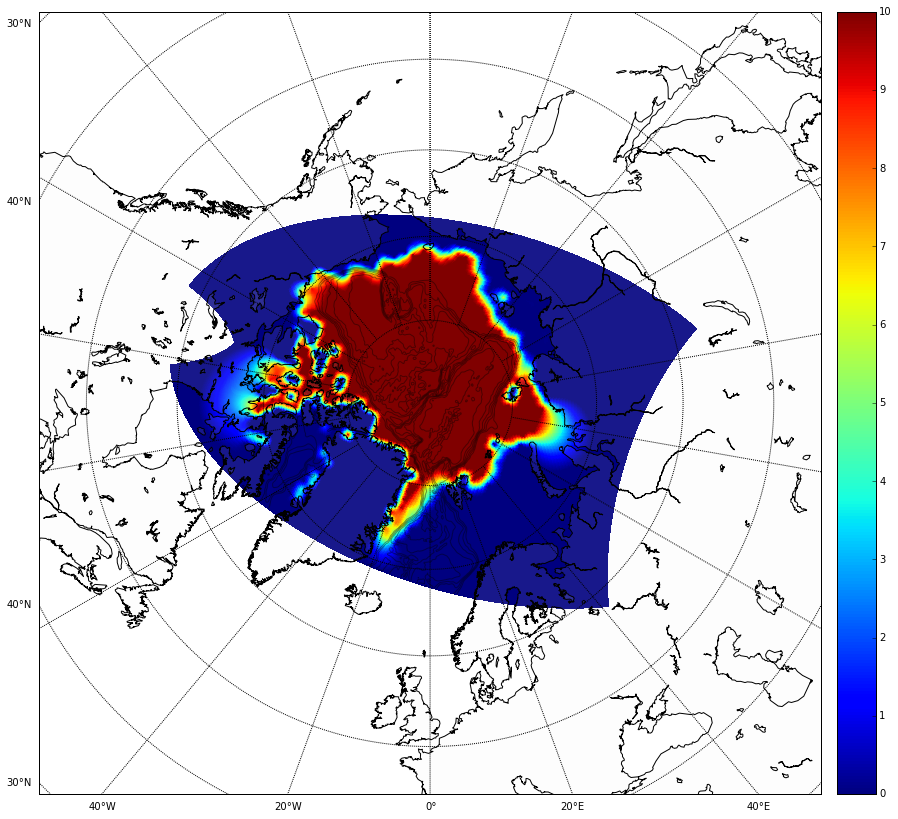

In [11]:
fig = plt.figure(figsize=(15,15))
m = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
m.drawcoastlines()

m.fillcontinents(color = '0.95',alpha=0.1)
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
m.contour(x_lon[435:-20,10:-20],y_lat[435:-20,10:-20],bathy[35:-20,10:-20],linewidth=0.075,colors='black',alpha=0.4)
m.pcolor(x_lon[435:-20,10:-20],y_lat[435:-20,10:-20],icon_)
m.colorbar()
#plt.legend(loc=1,fontsize=11,scatterpoints=1)
plt.show()

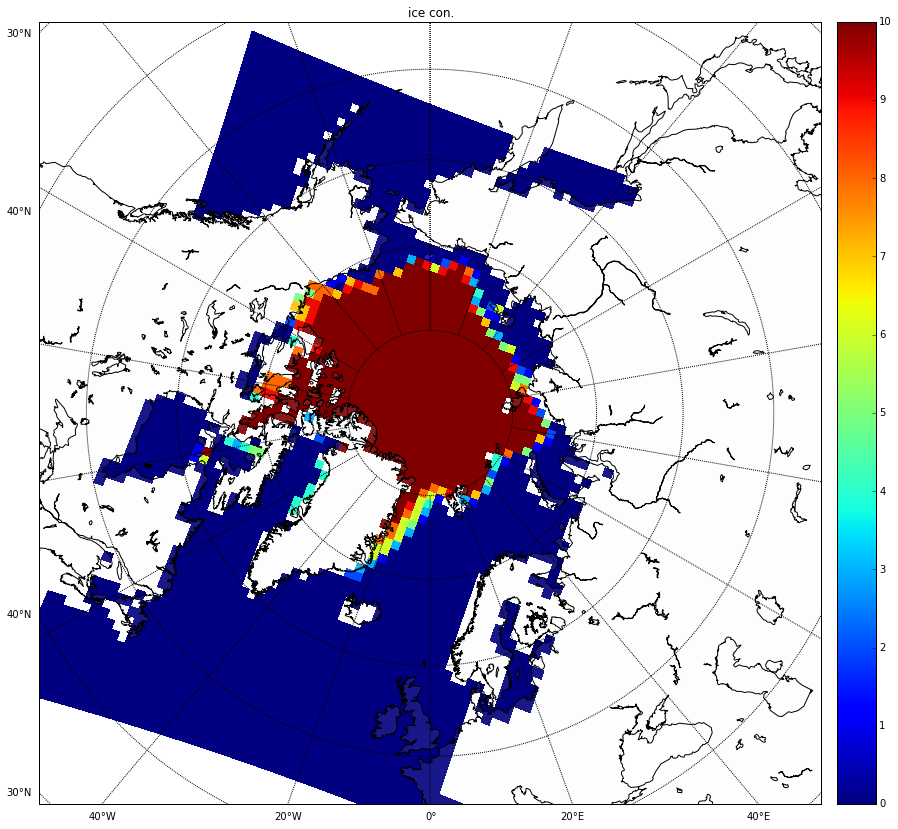

In [12]:
fig = plt.figure(figsize=(15,15))
m = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
m.drawcoastlines()

m.fillcontinents(color = '0.95',alpha=0.1)
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])

x,y= m(iconlon,iconlat)
m.pcolor(x,y,icon,vmin=0, vmax=10)
m.colorbar()

plt.title("ice con.")
plt.show()

In [13]:
icon_ANHA=np.zeros((800,544))
icon_ANHA[435:-20,10:-20]=icon_/10.

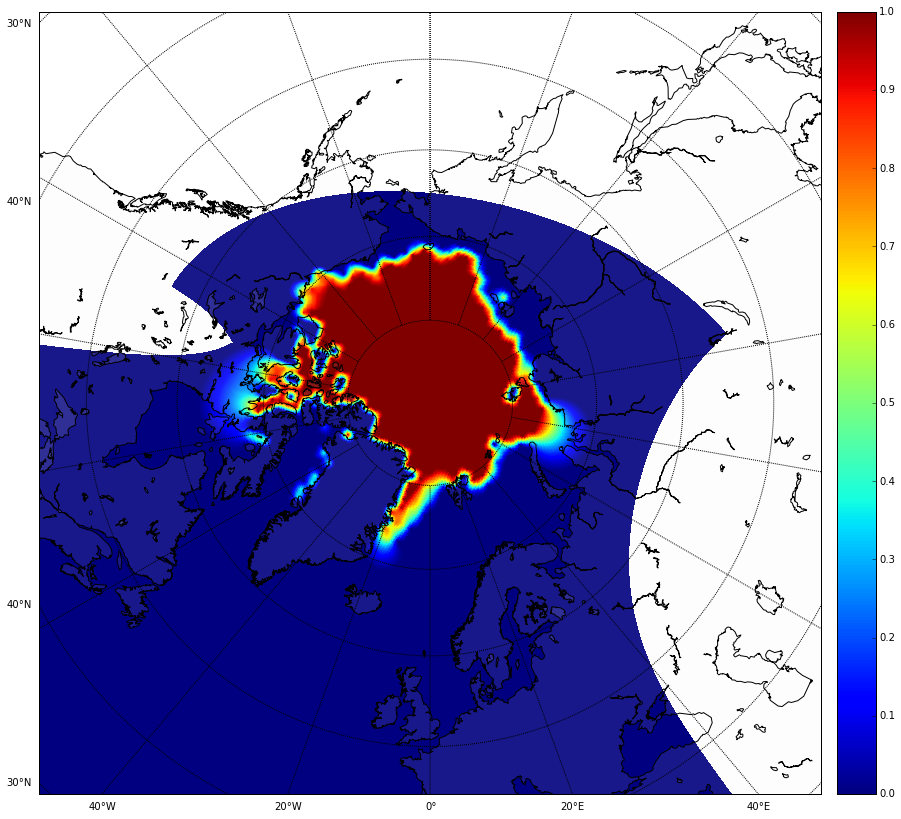

In [14]:
fig = plt.figure(figsize=(15,15))
m = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
m.drawcoastlines()

m.fillcontinents(color = '0.95',alpha=0.1)
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])

m.pcolor(x_lon,y_lat,icon_ANHA)
m.colorbar()

plt.show()

In [26]:
lat = nav_lat
lon = nav_lon
print lat.shape
xmax = lat.shape[1]
ymax = lat.shape[0]


nemo = nc.Dataset('/ocean/xiaoxiny/research/data/forcing/Ice/ANHA4-EXH001_icemod_y%sm09.nc'%yr, 'w')
nemo.description = 'ice' 

# dimensions
nemo.createDimension('x', xmax)
nemo.createDimension('y', ymax)
nemo.createDimension('time_counter', None)

# variables
# latitude and longitude
nav_lat = nemo.createVariable('nav_lat','float32',('y','x'),zlib=True)
nav_lat = lat
x = nemo.createVariable('nav_lon','float32',('y','x'),zlib=True)
nav_lon = lon
# time
time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'),zlib=True)
time_counter.units = 'non-dim'
time_counter[0] = 1
# runoff
Pa = nemo.createVariable('ileadfra', 'float32', ('y','x'), zlib=True)
Pa._units = 'arbitrary'
Pa[:,:]=icon_ANHA[:,:]
nemo.close()


(800, 544)


In [ ]:
# long code below

In [1]:
import numpy as np
import math
import os
import glob
import pandas as pd
from pylab import *
import netCDF4 as nc
from scipy.interpolate import griddata
from scipy.interpolate import Rbf
import re
from mpl_toolkits.basemap import Basemap,shiftgrid,cm
import matplotlib.cm as cm
import numpy
import matplotlib.pyplot as plt
    
def context2array(context):
    return np.matrix([map(float, re.split('\s+', ln.strip()))
      for ln in context.splitlines() if ln.strip()])
    
def regrid(yr):
    # load lons and lats
    file_source = open('/ocean/xiaoxiny/research/data/findk/ice_concentration/updated_lon.dat')
    line_content = file_source.readlines()
    lon_ice=np.empty([10,464])
    for j in range(0, 464):
         lon_ice[:,j] = context2array(line_content[j])
    
    file_source = open('/ocean/xiaoxiny/research/data/findk/ice_concentration/updated_lat.dat')
    line_content = file_source.readlines()
    lat_ice=np.empty([10,464])
    for j in range(0, 464):
         lat_ice[:,j] = context2array(line_content[j])
    # reshape        
    shape = ( 80, 58 )
    lon2_ice=lon_ice.reshape(shape)
    lat2_ice=lat_ice.reshape(shape)
    
    
    #rearrange lon_ice,lat_ice
    
    iconlat=np.empty([80,58])
    iconlon=np.empty([80,58])
    
    for j in range (58):
        for k in range (8):
                iconlat[k*10:(k+1)*10,j]=lat_ice[:,j*8+k]
                iconlon[k*10:(k+1)*10,j]=lon_ice[:,j*8+k]
    
    
    filename=sorted(glob.glob('/ocean/xiaoxiny/research/data/findk/ice_concentration/59,78,79/*%s*'%yr))
    print filename
    icon=np.empty([80,58])
    for k in range(1):
        file_source=open(filename[k])
        line_content = file_source.readlines()
        for i in range (58):
            split=map(''.join, zip(*[iter(line_content[i])]))
            for j in range (len(split)-1):
                if split[j]=='*':
                    split[j]=10
                if split[j]=='.':
                    split[j]=-1
                icon[j,i]=split[j] 
    
    icon=np.ma.masked_where(icon<0,icon)
    icon=np.ma.masked_where(np.isnan(icon),icon)
    
       
    
    coordinate_name=glob.glob('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/*coor*.nc')
    coordinate_obj=nc.Dataset(coordinate_name[0])
    nav_lon=coordinate_obj.variables['nav_lon'][:,:]
    nav_lat=coordinate_obj.variables['nav_lat'][:,:]
    
    # regrid
    m = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
    x_lon,y_lat = m(nav_lon, nav_lat)
    x,y= m(iconlon,iconlat)
    
    rbf = Rbf(x[15:52,10:-15], y[15:52,10:-15], icon[15:52,10:-15], function='linear')
    icon_ = rbf(x_lon[430:-10,15:-25], y_lat[430:-10,15:-25])
    
    #adjust limit
    icon_[icon_ < 0] = 0
    icon_[icon_ > 10] = 10
    
    
    
    icon_ANHA=np.zeros((1,800,544))
    #ice conc. from scale of 0-10 to 0-1
    icon_ANHA[0,430:-10,15:-25]=icon_/10.
    
    
    lat = nav_lat
    lon = nav_lon
    xmax = lat.shape[1]
    ymax = lat.shape[0]
    
    
    nemo = nc.Dataset('/ocean/xiaoxiny/research/data/forcing/Ice/noaa_icemod_y%sm09.nc'%yr, 'w')
    nemo.description = 'ice' 
    
    # dimensions
    nemo.createDimension('x', xmax)
    nemo.createDimension('y', ymax)
    nemo.createDimension('time_counter', None)
    
    # variables
    # latitude and longitude
    nav_lat = nemo.createVariable('nav_lat','float32',('y','x'),zlib=True)
    nav_lat = lat
    x = nemo.createVariable('nav_lon','float32',('y','x'),zlib=True)
    nav_lon = lon
    # time
    time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'),zlib=True)
    time_counter.units = 'non-dim'
    time_counter[0] = 1
    # runoff
    Pa = nemo.createVariable('ileadfra', 'float32', ('time_counter','y','x'), zlib=True)
    Pa._units = 'arbitrary'
    Pa[:,:,:]=icon_ANHA[:,:,:]
    nemo.close()
    
for yr in range (1957,1979):
    regrid(yr)    

['/ocean/xiaoxiny/research/data/findk/ice_concentration/59,78,79/1957_9']
['/ocean/xiaoxiny/research/data/findk/ice_concentration/59,78,79/1958_9']
['/ocean/xiaoxiny/research/data/findk/ice_concentration/59,78,79/1959_9']
['/ocean/xiaoxiny/research/data/findk/ice_concentration/59,78,79/1960_9']
['/ocean/xiaoxiny/research/data/findk/ice_concentration/59,78,79/1961_9']
['/ocean/xiaoxiny/research/data/findk/ice_concentration/59,78,79/1962_9']
['/ocean/xiaoxiny/research/data/findk/ice_concentration/59,78,79/1963_9']
['/ocean/xiaoxiny/research/data/findk/ice_concentration/59,78,79/1964_9']
['/ocean/xiaoxiny/research/data/findk/ice_concentration/59,78,79/1965_9']
['/ocean/xiaoxiny/research/data/findk/ice_concentration/59,78,79/1966_9']
['/ocean/xiaoxiny/research/data/findk/ice_concentration/59,78,79/1967_9']
['/ocean/xiaoxiny/research/data/findk/ice_concentration/59,78,79/1968_9']
['/ocean/xiaoxiny/research/data/findk/ice_concentration/59,78,79/1969_9']
['/ocean/xiaoxiny/research/data/findk/